# Geocentric models (lecture 3)

> https://youtu.be/tNOu-SEacNU

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.patches as patches
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Introduction

An model (statistical) may provide good predictions, even if it's (causally) completely wrong.

Linear regression is an example of a statistical model that predicts well, but generally fails to correctly explain causality since few phenomena are actually linearly related.

Case in point, ancient astronomers predicted the planetary retrograde phenomenon (planets zig-zags across the sky) within a geocentric model. They assumed the wrong thing, but the predictions worked anyway. In the geocentric model planets orbit around the Earth in epicycles, that is orbits on orbits. We now know that a different model (the iliocentric model) is a better representation of the solar system. The iliocentric model simultaneously predicts as well and correctly explains how planets move, namely in elliptic orbits around the sun. 

### Where do normal or gaussian distributions come from?

Generative argument: many small errors accumulate to the normal distribution because:
- small cumulative errors can be generated in many more ways than big cumulative errors

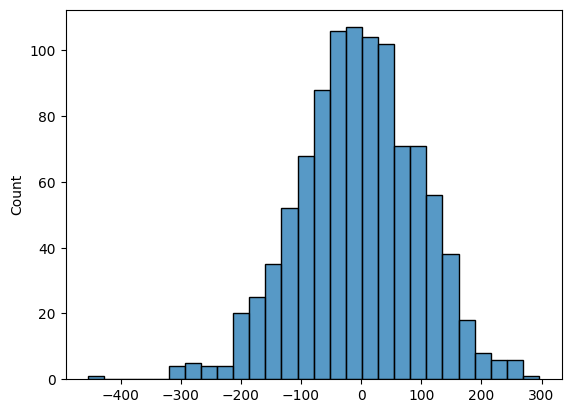

In [3]:
def football_flip(n, rounds):
    pos = np.zeros(n)
    for _ in range(rounds):
        delta = np.random.choice([-1, 1], size=n)
        pos += delta
    return pos

pos = football_flip(n=int(1e3), rounds=int(1e4))
sns.histplot(pos)
plt.show()

### Why are normal distributions a good first assumption?

They make the least claims about the distribution other than a central tendency and a variation around the mean.  

> A variable does not have to be (actually) normally distribution for normal models to be useful. It's a machine for estimating mean and variance.

## 1. Estimand 

## 2. Scientific/generative model

> How does height influence weight?

Variables:
- H = height
- W = weight
- U = unobserved influences on weight

Causal model:

```
                               ┌────┐
  H   ────────▶  W   ◀─────────│ U  │
                               └────┘
```

Weight as a function of height:

$$
\begin{align}
W = & \quad \beta \cdot H + U \\
U \sim & \quad Normal(0, \sigma) \\
H \sim & \quad Uniform(130, 170) \\
\end{align}
$$


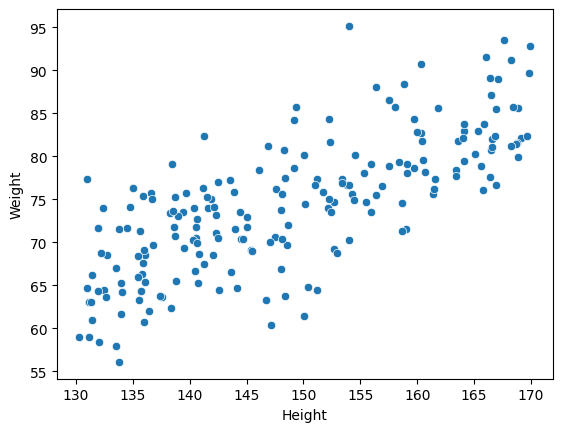

In [4]:
def sim_weight(H, beta, sd):
    U = np.random.normal(loc=0, scale=sd, size=len(H))
    W = beta*H + U
    return W

n = 200
heights = np.random.uniform(low=130, high=170, size=n)
weights = sim_weight(heights, beta=0.5, sd=5)
sns.scatterplot(x=heights, y=weights)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

## 3. Statistical model (estimator)

> How does average weight change with height?

Linear regression:

$$
E(W_i \mid H_i) = \alpha + \beta \cdot H_i
$$

Estimators are usually not exactly like generative model. Allows us to show us problems with generative model.

Goal: 
- Estimate how the average weight changes with height

### Posterior distribution

The only kind of estimator in Bayesian inference, but driven by different generative models.

$$
Pr(\alpha, \beta, \sigma \mid H_i, W_i) = \frac{Pr(W_i \mid H_i, \alpha, \beta, \sigma)Pr(\alpha, \beta, \sigma)}{Z}
$$

Variables
- Observed (known from observation, so don't need posterior distribution): $H, W$ 
- Unobserved (need to develop posterior distribution for them): $\alpha, \beta, \sigma$

Explanation of formula:
- LHS = posterior distribution of specific line
- RHS (upper, factor 1) = the number of ways we could see observations.
- RHS (upper, factor 2) = prior (i.e., the previous posterior distribution)
- RHS (lower) = normalising constant


### Constructing prior predictive distribution

Prior should express scientific knowledge, but *softly*. Should allow predictions that are not *crazy*, before seeing data.

Selecting sane priors:
- Humans with zero height weigh zero kg, therefore $\alpha \sim Normal(0, 10)$.
- Weight increases with height on average, and weight < height, therefore $\beta \sim Uniform(0,1)$ 
- Noise must be positive, but we don't know how much, therefore $\sigma \sim Uniform(0,10)$

Generate these priors, e.g., by testing what generated observations look like with these priors.

## Selecting priors

Using our scientific knowledge about the domain to assert reasonable, but also wide, priors or our estimands.

In [16]:
n = int(1e2)
alpha = np.random.normal(0, 10, size=n)
beta = np.random.uniform(0, 1, size=n)
sigma = np.random.uniform(0, 10, size=n)

### Sampling from prior distribution

Let's see what the priors look like graphically
- Some look ok
- Some look crazy

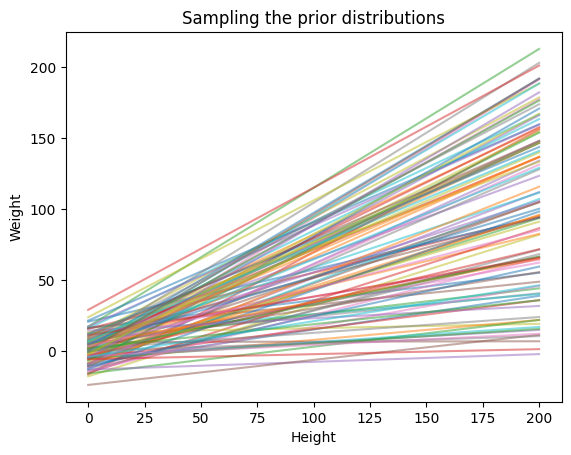

In [18]:
x0 = 0
x1 = 200

for i in range(n):
    y0 = alpha[i]
    y1 = beta[i]*x1 + alpha[i]
    plt.plot([x0, x1], [y0, y1], alpha=0.5)
plt.title('Sampling the prior distributions')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()


### Quadratic approximation

Need an implementation of quap in Python

> import pymc as pm  # pip install pymc

Documentation links:
- https://gist.github.com/AustinRochford/1cbe9acd50b2ffc7e00463086d068cc2

In [8]:
SEED = 42
with pm.Model() as monty_model:
    car = pm.DiscreteUniform("car", 0, 2)

In [4]:
data = np.repeat([0, 1], (10, 3))
with pm.Model() as normal_approximation:
    p = pm.Beta('p', 1., 1.)
    w = pm.Binomial('w',n=1, p=p, observed=data)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
mean_q['p'], std_q


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: InplaceDimShuffle{}(TensorConstant{(1,) of 13})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1918, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1078, in transform
    return self.fn(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1138, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/link/c/op.py", line 131, in make_thunk
    return sel


You can find the C code in this temporary file: /tmp/pytensor_compilation_error_yge7kd0w


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: InplaceDimShuffle{}(TensorConstant{(1,) of 13})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1918, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1078, in transform
    return self.fn(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1138, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/link/c/op.py", line 131, in make_thunk
    return sel


You can find the C code in this temporary file: /tmp/pytensor_compilation_error_cdw4n75h


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: InplaceDimShuffle{}(TensorConstant{(1,) of 13})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1918, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1078, in transform
    return self.fn(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1138, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/link/c/op.py", line 131, in make_thunk
    return sel


You can find the C code in this temporary file: /tmp/pytensor_compilation_error__15kz0er


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Elemwise{true_div,no_inplace}(TensorConstant{1.0}, TensorConstant{2.0})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1918, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1078, in transform
    return self.fn(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1138, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/link/c/op.py", line 131, in m


You can find the C code in this temporary file: /tmp/pytensor_compilation_error_q6pqfzu5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Elemwise{add,no_inplace}(TensorConstant{0.5}, TensorConstant{0.5})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1918, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1078, in transform
    return self.fn(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1138, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/link/c/op.py", line 131, in make_t


You can find the C code in this temporary file: /tmp/pytensor_compilation_error_ueigjwr0


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Elemwise{true_div,no_inplace}(TensorConstant{1.0}, TensorConstant{1.0})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1918, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1078, in transform
    return self.fn(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1138, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/link/c/op.py", line 131, in m


You can find the C code in this temporary file: /tmp/pytensor_compilation_error_1l4krkjc


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Elemwise{log,no_inplace}(TensorConstant{1.0})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1918, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1078, in transform
    return self.fn(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1138, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/link/c/op.py", line 131, in make_thunk
    return self.


You can find the C code in this temporary file: /tmp/pytensor_compilation_error_0nk65rwt


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Elemwise{log,no_inplace}(TensorConstant{1.0})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1918, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1078, in transform
    return self.fn(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1138, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/link/c/op.py", line 131, in make_thunk
    return self.


You can find the C code in this temporary file: /tmp/pytensor_compilation_error_bolr0mta


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Elemwise{log,no_inplace}(TensorConstant{1.0})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1918, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1078, in transform
    return self.fn(fgraph, node)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/tensor/rewriting/basic.py", line 1138, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/link/c/op.py", line 131, in make_thunk
    return self.


You can find the C code in this temporary file: /tmp/pytensor_compilation_error_v7ye9y65

You can find the C code in this temporary file: /tmp/pytensor_compilation_error_kj27n46s


CompileError: Compilation failed (return status=1):
/usr/bin/g++ -shared -g -Wno-c++11-narrowing -fno-exceptions -fno-unwind-tables -fno-asynchronous-unwind-tables -march=skylake-avx512 -mmmx -mno-3dnow -msse -msse2 -msse3 -mssse3 -mno-sse4a -mcx16 -msahf -mmovbe -maes -mno-sha -mpclmul -mpopcnt -mabm -mno-lwp -mfma -mno-fma4 -mno-xop -mbmi -mno-sgx -mbmi2 -mno-pconfig -mno-wbnoinvd -mno-tbm -mavx -mavx2 -msse4.2 -msse4.1 -mlzcnt -mrtm -mhle -mrdrnd -mf16c -mfsgsbase -mrdseed -mprfchw -madx -mfxsr -mxsave -mxsaveopt -mavx512f -mno-avx512er -mavx512cd -mno-avx512pf -mno-prefetchwt1 -mclflushopt -mxsavec -mxsaves -mavx512dq -mavx512bw -mavx512vl -mno-avx512ifma -mno-avx512vbmi -mno-avx5124fmaps -mno-avx5124vnniw -mno-clwb -mno-mwaitx -mno-clzero -mno-pku -mno-rdpid -mno-gfni -mno-shstk -mno-avx512vbmi2 -mno-avx512vnni -mno-vaes -mno-vpclmulqdq -mno-avx512bitalg -mno-avx512vpopcntdq -mno-movdiri -mno-movdir64b -mno-waitpkg -mno-cldemote -mno-ptwrite --param l1-cache-size=32 --param l1-cache-line-size=64 --param l2-cache-size=36608 -mtune=skylake-avx512 -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -m64 -fPIC -I/home/codespace/.local/lib/python3.10/site-packages/numpy/core/include -I/usr/local/python/3.10.4/include/python3.10 -I/home/codespace/.python/current/lib/python3.10/site-packages/pytensor/link/c/c_code -L/usr/local/python/3.10.4/lib -L/home/codespace/.python/current/lib -fvisibility=hidden -o /home/codespace/.pytensor/compiledir_Linux-5.4--azure-x86_64-with-glibc2.31-x86_64-3.10.4-64/lazylinker_ext/lazylinker_ext.so /home/codespace/.pytensor/compiledir_Linux-5.4--azure-x86_64-with-glibc2.31-x86_64-3.10.4-64/lazylinker_ext/mod.cpp -lpython3.10
/usr/bin/ld: /usr/local/python/3.10.4/lib/libpython3.10.a(bytearrayobject.o): relocation R_X86_64_PC32 against symbol `_Py_NoneStruct' can not be used when making a shared object; recompile with -fPIC
/usr/bin/ld: final link failed: bad value
collect2: error: ld returned 1 exit status


## 4. Validate model

TODO, because we didn't finish the statistical model (quap)

Bare mimimum:
- Test statistical model with simulated observations from scientific model